# Loop comparison

Since in the first notebook, `MPS-STATEVECT_IRIS`, we saw that the MPS was performing better than the statevector we decided to average them over some loops to understand if the problem was some seed which was not setted correctly.

In [123]:
from qiskit import QuantumCircuit, execute
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit_machine_learning.algorithms import VQC
from qiskit_machine_learning.datasets import iris
from qiskit.providers.aer import QasmSimulator

import numpy as np
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
import pandas as pd

seed = 1376
algorithm_globals.random_seed = seed

## Data preparation

First, we use the [iris dataset](https://archive.ics.uci.edu/ml/datasets/iris). It has $4$ features, thus needing a $4$-qubit circuit, and $3$ classes. However, we are interested in doing only a binary classification. This means that we have to eliminate a class, and we will eliminate the third class for simplicity.

In [124]:
# Use Iris data set for training and test data
feature_dim = 4  # dimension of each data point
training_size = 100
test_size = 30

# training features, training labels, test features, test labels as np.array,
# one hot encoding for labels
training_features, training_labels, test_features, test_labels = \
    iris(training_size=training_size, test_size=test_size, n=feature_dim)

In [125]:
training_features = training_features[ training_labels[:, 2]!=1 ]
training_labels = training_labels[ training_labels[:, 2]!=1, :2 ]

test_features = test_features[ test_labels[:, 2]!=1 ]
test_labels = test_labels[ test_labels[:, 2]!=1, :2 ]

## Circuit preparation
We use a ZZFeature map, with linear entanglement (i.e. only local gates), to map the data points to the quantum circuit, and then a TwoLocal ansazt as neural network, having $8$ trainable parameters.

In [126]:
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear', insert_barriers=True)
ansatz = TwoLocal(feature_map.num_qubits, ['ry'], 'cx', reps=1, entanglement='linear')

In [128]:
# Definition with statevector simulator
vqc_sv = VQC(feature_map=feature_map,
          ansatz=ansatz,
          optimizer=COBYLA(maxiter=50),
          quantum_instance=QuantumInstance( QasmSimulator(method='statevector'),
                                           shots=1024,
                                           seed_simulator=seed,
                                           seed_transpiler=seed),
          warm_start=True
          )
vqc_sv._fit_result = [starting_params ]

# Definition with mps
vqc_mps = VQC(feature_map=feature_map,
          ansatz=ansatz,
          optimizer=COBYLA(maxiter=50),
          quantum_instance=QuantumInstance(backend= QasmSimulator(method='matrix_product_state',
                                                                  matrix_product_state_max_bond_dimension=4),
                                           shots=1024,
                                           seed_simulator=seed,
                                           seed_transpiler=seed),
          warm_start=True
          )

vqc_mps._fit_result = [starting_params ]

In [130]:
# Statistics for the STATEVECT
run = True
if run:
    np.random.seed(123)
    score_sv = []
    for i in tqdm(range(30)):
        starting_params = np.random.uniform(-1, 1, len(ansatz.parameters))
        vqc_sv._fit_result = [starting_params ]
        vqc_sv.fit(training_features, training_labels)
        score_sv += [ vqc_sv.score(training_features, training_labels) ]
        print(starting_params, score_sv[i])

  3%|██▋                                                                             | 1/30 [11:00<5:19:01, 660.04s/it]

[ 0.39293837 -0.42772133 -0.54629709  0.10262954  0.43893794 -0.15378708
  0.9615284   0.36965948] 0.6565656565656566


  7%|█████▎                                                                          | 2/30 [22:09<5:10:33, 665.49s/it]

[-0.0381362  -0.21576496 -0.31364397  0.45809941 -0.12285551 -0.88064421
 -0.20391149  0.47599081] 0.8282828282828283


 10%|████████                                                                        | 3/30 [33:25<5:01:40, 670.38s/it]

[-0.63501654 -0.64909649  0.06310275  0.06365517  0.26880192  0.69886359
  0.44891065  0.22204702] 0.7575757575757576


 10%|████████                                                                        | 3/30 [41:46<6:16:01, 835.61s/it]


KeyboardInterrupt: 

In [11]:
# Statistics for the MPS
run = False
if run:
    np.random.seed(123)
    score_mps = []
    for i in tqdm(range(30)):
        # Setting starting parameters
        starting_params = np.random.uniform(-1, 1, len(ansatz.parameters))
        vqc_mps._fit_result = [starting_params ]
        # Fit
        vqc_mps.fit(training_features, training_labels)
        score_mps += [ vqc_mps.score(training_features, training_labels) ]
        print(starting_params, score_mps[i])

  3%|██▋                                                                             | 1/30 [04:27<2:09:22, 267.68s/it]

[ 0.39293837 -0.42772133 -0.54629709  0.10262954  0.43893794 -0.15378708
  0.9615284   0.36965948] 0.6565656565656566


  7%|█████▎                                                                          | 2/30 [08:31<1:58:27, 253.85s/it]

[-0.0381362  -0.21576496 -0.31364397  0.45809941 -0.12285551 -0.88064421
 -0.20391149  0.47599081] 0.8282828282828283


 10%|████████                                                                        | 3/30 [13:16<2:00:35, 267.98s/it]

[-0.63501654 -0.64909649  0.06310275  0.06365517  0.26880192  0.69886359
  0.44891065  0.22204702] 0.7575757575757576


 13%|██████████▋                                                                     | 4/30 [19:00<2:09:04, 297.85s/it]

[ 0.44488677 -0.35408217 -0.27642269 -0.54347354 -0.41257191  0.26195225
 -0.81579012 -0.13259765] 0.8181818181818182


 17%|█████████████▎                                                                  | 5/30 [24:54<2:12:37, 318.29s/it]

[-0.13827447 -0.0126298  -0.14833942 -0.37547755 -0.14729739  0.78677833
  0.88832004  0.00367335] 0.8181818181818182


 20%|████████████████                                                                | 6/30 [30:46<2:11:48, 329.54s/it]

[ 0.2479059  -0.76876321 -0.36542904 -0.17034758  0.73261832 -0.49908927
 -0.03393147  0.97111957] 0.8080808080808081


 23%|██████████████████▋                                                             | 7/30 [36:37<2:09:01, 336.61s/it]

[ 0.03897024  0.22578905 -0.75874267  0.6526816   0.20612026  0.09013601
 -0.31447233 -0.39175842] 0.797979797979798


 27%|█████████████████████▎                                                          | 8/30 [42:23<2:04:29, 339.51s/it]

[-0.16595558  0.36260153  0.75091368  0.02084467  0.33862757  0.17187311
  0.249807    0.3493781 ] 0.7777777777777778


 30%|████████████████████████                                                        | 9/30 [48:23<2:01:06, 346.02s/it]

[ 0.68468488 -0.83361002  0.52736568 -0.51266725 -0.61155408  0.14491391
 -0.80857497  0.77065365] 0.8080808080808081


 33%|██████████████████████████▎                                                    | 10/30 [54:29<1:57:23, 352.16s/it]

[ 0.25449794  0.44683272 -0.96774159  0.18886376  0.11357038 -0.68208071
 -0.69385897  0.39105906] 0.8383838383838383


 37%|████████████████████████████▏                                                | 11/30 [1:00:41<1:53:27, 358.29s/it]

[-0.36246715  0.38394059  0.1087665  -0.22209885  0.85026498  0.68333999
 -0.28520487 -0.91281707] 0.8383838383838383


 40%|██████████████████████████████▊                                              | 12/30 [1:07:05<1:49:49, 366.10s/it]

[-0.39046385 -0.20362864  0.40991766  0.99071696 -0.28817027  0.52509563
  0.18635383  0.3834036 ] 0.797979797979798


 43%|█████████████████████████████████▎                                           | 13/30 [1:13:35<1:45:47, 373.40s/it]

[-0.6977451  -0.20224741 -0.5182882  -0.31308797  0.02625631  0.3332491
 -0.78818303 -0.7382101 ] 0.6363636363636364


 47%|███████████████████████████████████▉                                         | 14/30 [1:20:09<1:41:12, 379.54s/it]

[-0.35603879  0.32312867  0.69301245  0.10651469  0.70890498 -0.23032438
 -0.36642421 -0.29147065] 0.696969696969697


 50%|██████████████████████████████████████▌                                      | 15/30 [1:26:54<1:36:50, 387.36s/it]

[-0.65783634  0.65822527 -0.32265831  0.10474015  0.15710294  0.04306612
 -0.99462387  0.97669084] 0.6262626262626263


 53%|█████████████████████████████████████████                                    | 16/30 [1:34:48<1:36:25, 413.26s/it]

[ 0.81068315 -0.58472828 -0.41502117  0.04002031  0.80382275  0.96726177
 -0.48491587  0.12871809] 0.7777777777777778


 57%|███████████████████████████████████████████▋                                 | 17/30 [1:41:41<1:29:30, 413.10s/it]

[ 0.61393737 -0.21125989  0.46214607 -0.67786197  0.20139714  0.73172892
  0.96704322 -0.84126842] 0.7878787878787878


 60%|██████████████████████████████████████████████▏                              | 18/30 [1:48:38<1:22:52, 414.41s/it]

[-0.14330545 -0.59091428 -0.09872702  0.09552715 -0.81334658 -0.40627845
  0.85516848  0.13800746] 0.6363636363636364


 63%|████████████████████████████████████████████████▊                            | 19/30 [1:55:51<1:17:01, 420.14s/it]

[-0.085176    0.50705198  0.4837243  -0.90284193  0.41739479  0.6784867
 -0.66812423  0.56199588] 0.8181818181818182


 67%|███████████████████████████████████████████████████▎                         | 20/30 [2:03:07<1:10:46, 424.66s/it]

[-0.42692677 -0.38706049  0.33052293 -0.77721566  0.3297449   0.77571359
  0.39262254 -0.11934425] 0.6363636363636364


 70%|█████████████████████████████████████████████████████▉                       | 21/30 [2:10:36<1:04:48, 432.04s/it]

[-0.12357123  0.53019219  0.131284   -0.83019167  0.16534218  0.62968741
 -0.32586723  0.85515316] 0.797979797979798


 73%|█████████████████████████████████████████████████████████▉                     | 22/30 [2:16:15<53:54, 404.28s/it]

[ 0.501434    0.14812765  0.50328798 -0.84170208  0.71877815  0.64300823
  0.81974332 -0.7427376 ] 0.8282828282828283


 77%|████████████████████████████████████████████████████████████▌                  | 23/30 [2:22:31<46:09, 395.63s/it]

[-0.83643983 -0.72316885 -0.20124258 -0.15138628  0.12443676 -0.7555129
 -0.597201    0.6232887 ] 0.8282828282828283


 80%|███████████████████████████████████████████████████████████████▏               | 24/30 [2:29:45<40:43, 407.27s/it]

[-0.06402485  0.61587642 -0.98514724  0.10318545  0.8638643   0.16435092
 -0.58780855  0.43551512] 0.797979797979798


 83%|█████████████████████████████████████████████████████████████████▊             | 25/30 [2:37:02<34:39, 415.95s/it]

[-0.2420283   0.33676789 -0.94136055  0.27180072 -0.93560413  0.48956131
 -0.054174   -0.75649129] 0.7878787878787878


 87%|████████████████████████████████████████████████████████████████████▍          | 26/30 [2:44:28<28:20, 425.07s/it]

[ 0.08527185 -0.86645111  0.30672974  0.99217265  0.53879467  0.14754823
 -0.79472948  0.39966815] 0.6262626262626263


 90%|███████████████████████████████████████████████████████████████████████        | 27/30 [2:51:33<21:14, 424.95s/it]

[ 0.32233573 -0.90180574  0.5845986   0.03743318 -0.14826461  0.57637435
 -0.17686155 -0.03794745] 0.8181818181818182


 93%|█████████████████████████████████████████████████████████████████████████▋     | 28/30 [2:56:40<12:59, 389.83s/it]

[-0.63674231 -0.3573622   0.69106599 -0.6261925  -0.16541788  0.97806901
 -0.52680038  0.83366467] 0.7878787878787878


 97%|████████████████████████████████████████████████████████████████████████████▎  | 29/30 [3:01:54<06:06, 366.91s/it]

[ 0.83679494 -0.81740732 -0.07269455  0.00443267 -0.3726621  -0.90532093
 -0.51662873 -0.80894072] 0.7878787878787878


100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [3:07:15<00:00, 374.53s/it]

[-0.52350019  0.61558217  0.78995658 -0.91355422 -0.39610633  0.9611644
  0.07900965  0.25261872] 0.797979797979798


In [26]:
save = False
load = True
if save:
    scores = np.array([score_mps, score_sv] ).transpose()
    dataframe = pd.DataFrame(scores, columns=['Score_mps', 'Score_sv'])
    dataframe.to_csv('data/Loop-comparison/scores.csv')
    
if load:
    dataframe = pd.read_csv('data/Loop-comparison/scores.csv')

In [31]:
mean_mps = dataframe['Score_mps'].mean()
std_mps = dataframe['Score_mps'].std()

mean_sv = dataframe['Score_sv'].mean()
std_sv = dataframe['Score_sv'].std()

print(f'Score MPS: ({np.round(mean_mps, 3)}+- {np.round(std_mps, 3)})')
print(f'Score STATEVECTOR: ({np.round(mean_sv, 3)}+- {np.round(std_sv, 3)})')

Score MPS: (0.767+- 0.072)
Score STATEVECTOR: (0.759+- 0.074)


In [41]:
vqc_mps.neural_network.forward(training_features[1], vqc_mps._fit_result[0])

array([[0.46191406, 0.53808594]])

In [42]:
vqc_sv.neural_network.forward(training_features[1], vqc_sv._fit_result[0])

array([[0.47680365, 0.52319635]])

## Low level check

Try to run directly the circuit as low level as possible

In [53]:
def bind_params(qc, params):
    """ Bind parameters of a generic qiskit circuits

    Parameter
    ---------
    qc: QuantumCircuit
      Quantum circuit object
    params: array_like
      Values of the parameters to assign

    Returns
    -------
    binded_circ: QuantumCircuit
      Circuit where the parameters has been fixed
    """
    assert len(qc.parameters)==len(params), 'Array of values and parameters must have the same length'
    values = {}
    for p_val, p_key in zip(params, qc.parameters):
        values[p_key] = p_val
    binded_circ = qc.bind_parameters(values)
    return binded_circ

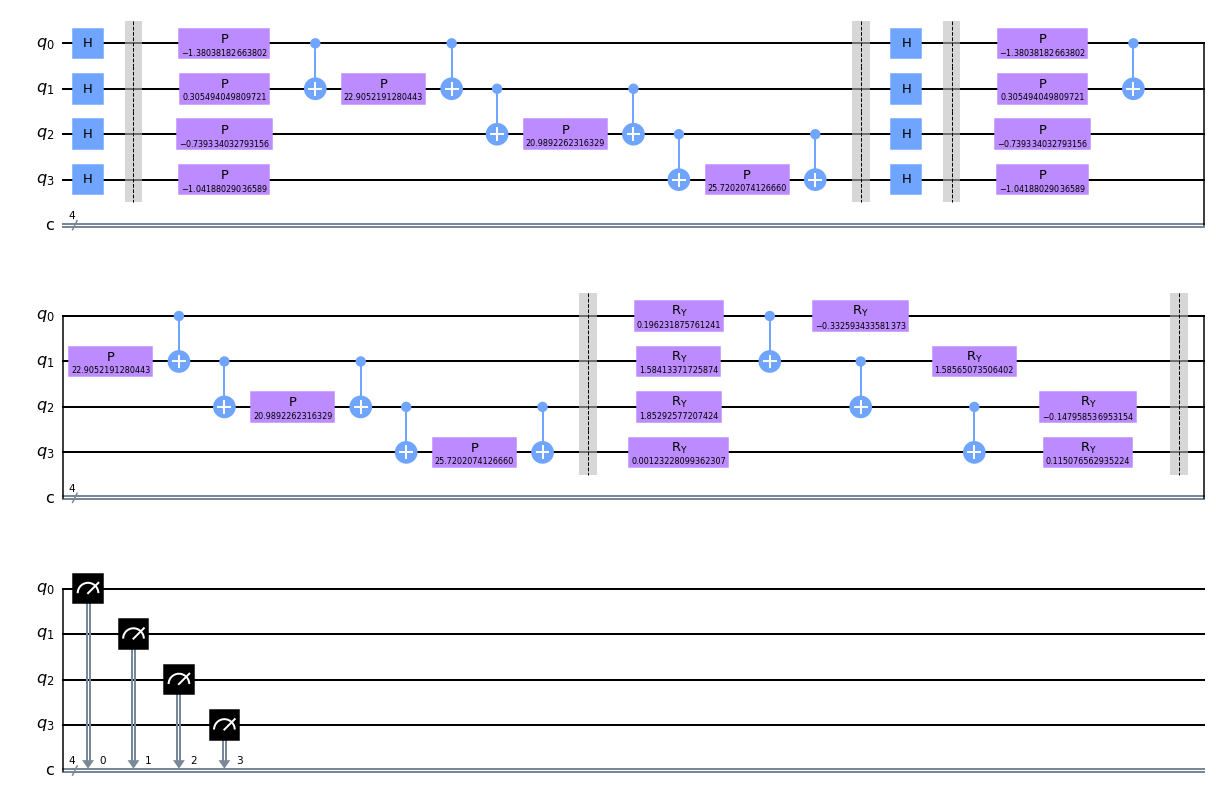

In [111]:
idx = 1

qc = QuantumCircuit(feature_dim, feature_dim)

binded_feature_map = bind_params(feature_map, training_features[idx])
binded_ansatz = bind_params(ansatz, vqc_sv._fit_result[0])

qc.append(binded_feature_map, range(feature_dim))
qc.barrier()
qc.append(binded_ansatz, range(feature_dim))
#qc.save_statevector(label='my_sv')

qc.barrier()
qc.measure(range(feature_dim), range(feature_dim))

qc.decompose().draw('mpl')

In [120]:
seed = 123

job_sv = execute(qc, QasmSimulator(method='statevector'), seed_simulator=seed, seed_transpiler=seed, shots=1024)

mps_backend = QasmSimulator(method='matrix_product_state', matrix_product_state_max_bond_dimension=4)
job_mps = execute(qc, mps_backend, seed_simulator=seed, seed_transpiler=seed, shots=1024)


In [122]:
#statevect_sv = job_sv.result().data()['statevector']
measures_sv = job_sv.result()

print(job_sv.result().data())
print(job_mps.result().data())

#statevect_mps = job_mps.result().data()['my_sv']

{'counts': {'0xf': 84, '0xc': 91, '0x0': 114, '0x1': 204, '0x2': 60, '0xd': 70, '0x5': 96, '0x7': 4, '0xe': 63, '0x8': 49, '0xb': 79, '0x6': 59, '0x9': 19, '0x3': 18, '0x4': 13, '0xa': 1}}
{'counts': {'0xf': 84, '0xc': 91, '0x0': 114, '0x1': 204, '0x2': 60, '0xd': 70, '0x5': 96, '0x7': 4, '0xe': 63, '0x8': 49, '0xb': 79, '0x6': 59, '0x9': 19, '0x3': 18, '0x4': 13, '0xa': 1}}


In [114]:
(statevect_sv*np.conjugate(statevect_mps) ).sum()

(0.4627770373520579-1.554312234475219e-14j)

In [108]:
for i, j in zip(statevect_sv, statevect_mps):
    print(i, j)

0j (0.3270186733657475-0.12358775218275792j)
(0.682417093779734+0.7309630018798636j) (0.31580696089777544+0.33827289242394065j)
0j (0.0742039291426986+0.2300514739448022j)
0j (-0.11564507189213943+0.08103258143445123j)
0j (-0.1160612596179072+0.08092578300571261j)
0j (-0.2973118702094664+0.03637743669996338j)
0j (0.018943570989509467-0.2333917200469279j)
0j (-0.0633052986026058-0.04376728409050666j)
0j (0.1804725482139832-0.10930557178553664j)
0j (0.036427377956112804+0.11191842250647978j)
0j (0.013003065383765002+0.006916356285244755j)
0j (0.11043603136083885-0.21686264821409068j)
0j (-0.1903519983128035+0.24184278999416187j)
0j (-0.25285152915595105+0.08812324071461342j)
0j (0.08308180257974995-0.20570796873224895j)
0j (-0.22202429875905563+0.17892458900749653j)
